Initial explanation about the project.

Since our dataset is already preprocessed we can just simply import the desired tools and load the data. First we will analyse our dataset.

In [169]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
import sklearn as skl
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder 
from imblearn.over_sampling import SMOTE
import seaborn as sea


dataframe = pd.read_csv('data.csv')

dataframe.info()
dataframe.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance                      4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nacionality                                     4424 non-null   int64  
 8   Mother's qualification                          4424 non-null   int64  
 9   Father's qualification                   

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,...,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000
mean,1.178571,18.669078,1.727848,8856.642631,0.890823,4.577758,132.613314,1.873192,19.561935,22.275316,...,0.137658,0.541817,6.232143,8.063291,4.435805,10.230206,0.150316,11.566139,1.228029,0.001969
std,0.605747,17.484682,1.313793,2063.566416,0.311897,10.216592,13.188332,6.914514,15.603186,15.343108,...,0.690880,1.918546,2.195951,3.947951,3.014764,5.210808,0.753774,2.663850,1.382711,2.269935
min,1.000000,1.000000,0.000000,33.000000,0.000000,1.000000,95.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000
25%,1.000000,1.000000,1.000000,9085.000000,1.000000,1.000000,125.000000,1.000000,2.000000,3.000000,...,0.000000,0.000000,5.000000,6.000000,2.000000,10.750000,0.000000,9.400000,0.300000,-1.700000
50%,1.000000,17.000000,1.000000,9238.000000,1.000000,1.000000,133.100000,1.000000,19.000000,19.000000,...,0.000000,0.000000,6.000000,8.000000,5.000000,12.200000,0.000000,11.100000,1.400000,0.320000
75%,1.000000,39.000000,2.000000,9556.000000,1.000000,1.000000,140.000000,1.000000,37.000000,37.000000,...,0.000000,0.000000,7.000000,10.000000,6.000000,13.333333,0.000000,13.900000,2.600000,1.790000
max,6.000000,57.000000,9.000000,9991.000000,1.000000,43.000000,190.000000,109.000000,44.000000,44.000000,...,12.000000,19.000000,23.000000,33.000000,20.000000,18.571429,12.000000,16.200000,3.700000,3.510000


Now we will check the distrubution of our target variable.

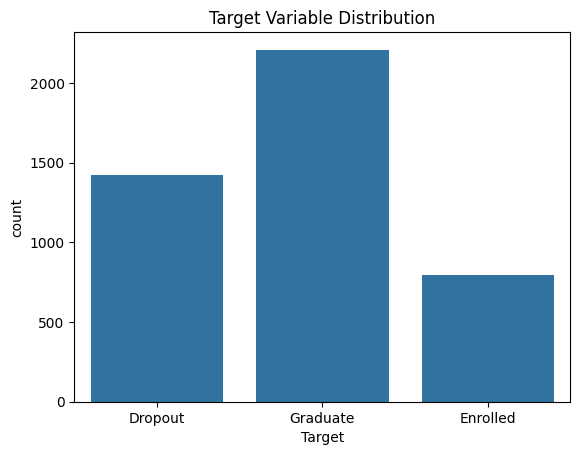

In [170]:
sea.countplot(x='Target', data = dataframe)
plt.title('Target Variable Distribution')
plt.show()

We should also consider the correlation between numerical variables. Let's check it out

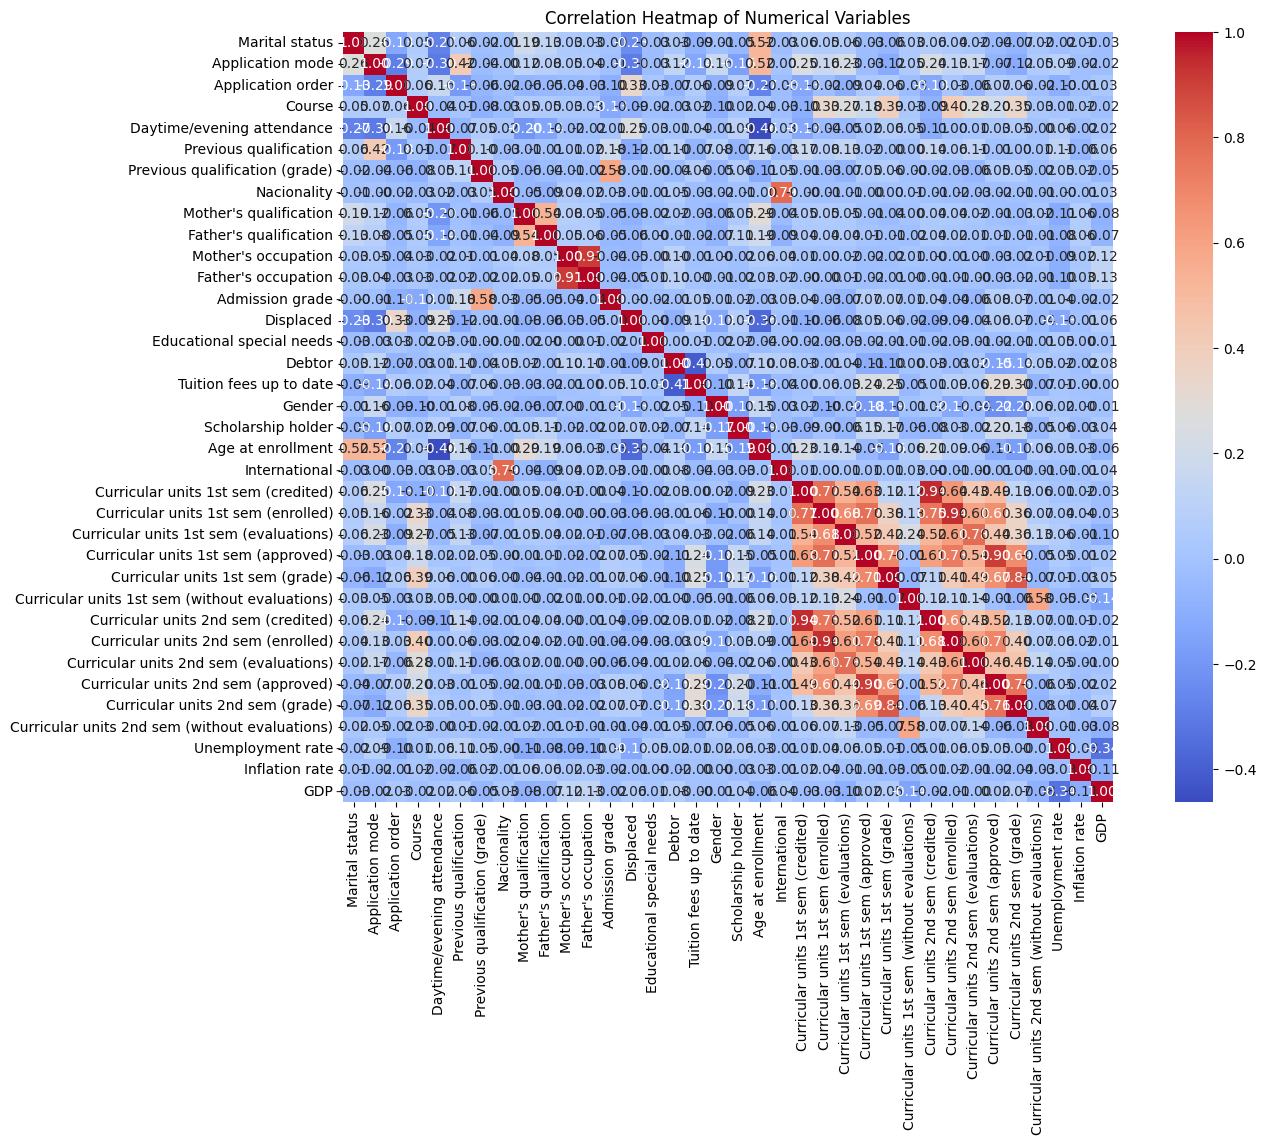

In [171]:
#this is kinda pointless since all variables are numberical if i'm not mistaken
numerical_df = dataframe.select_dtypes(include=['number']) 
correlation_matrix = numerical_df.corr()
plt.figure(figsize=(16, 10))
sea.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Heatmap of Numerical Variables')
plt.show()

However, this does not look good, we can't interpret it. Let's put a trehshold, so that only varaibles above the threshold are considered.

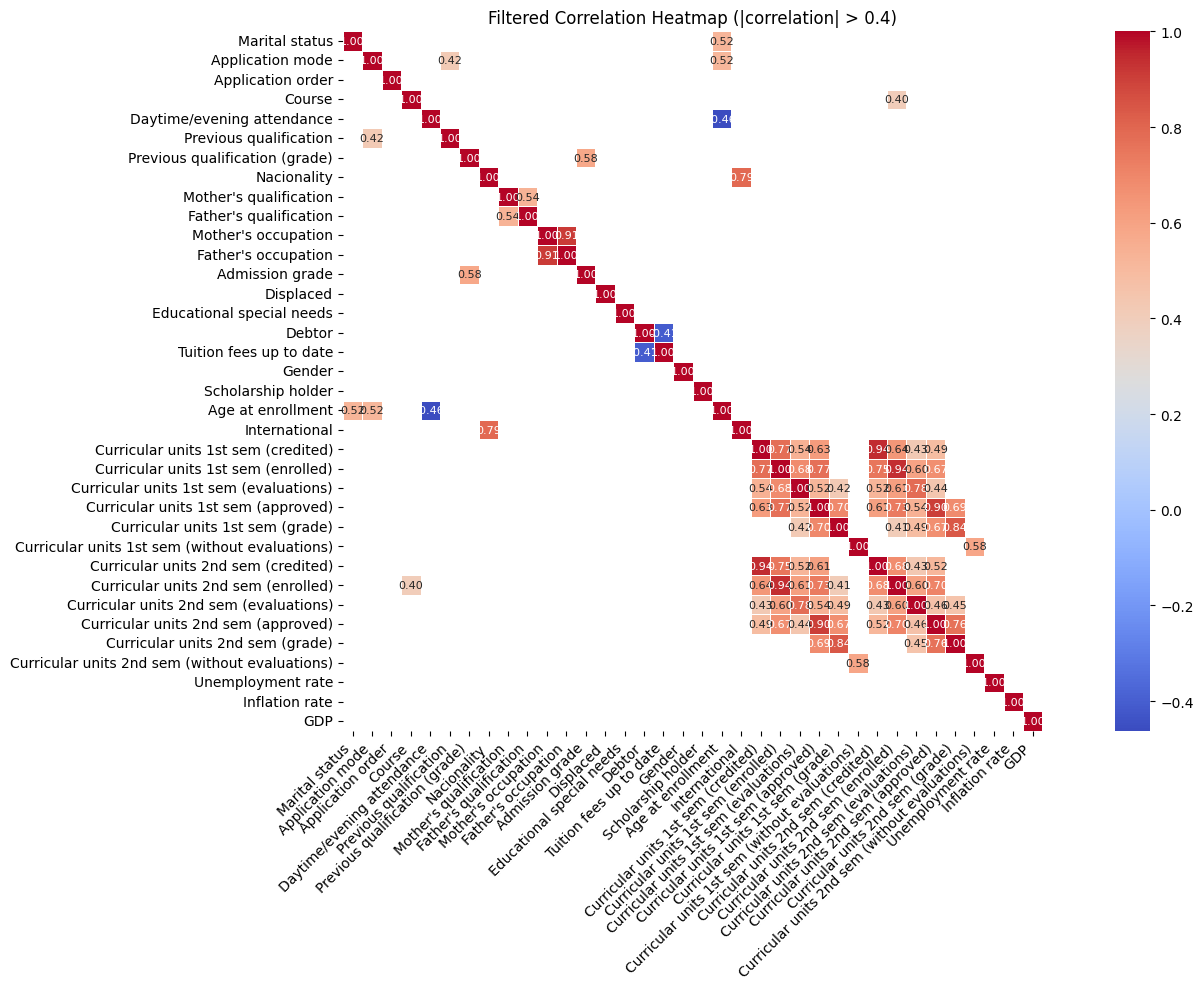

In [172]:
threshold = 0.4
mask = (abs(correlation_matrix) < threshold)

plt.figure(figsize=(16, 10))
sea.heatmap(correlation_matrix.mask(mask), annot=True, cmap='coolwarm', fmt=".2f",
            annot_kws={"size": 8}, square=True, linewidths=0.5)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Filtered Correlation Heatmap (|correlation| > 0.4)')
plt.tight_layout()
plt.show()

We wanna see the correlation between our variables and our target variable, however, our target is a string, so will have to encode it. 
After encoding our target variable we will set our X and Y axis.

In [173]:
le = LabelEncoder()

dataframe['Target'] = le.fit_transform(dataframe['Target'])

x_axis = dataframe.drop('Target', axis=1)
y_axis = dataframe['Target']


Since our target is now encoded we can check the correlation between varaibles and the target.

C:\Users\andre\AppData\Local\Temp\ipykernel_13500\1045841254.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sea.barplot(x=strong_correlations.values, y=strong_correlations.index, palette='coolwarm')


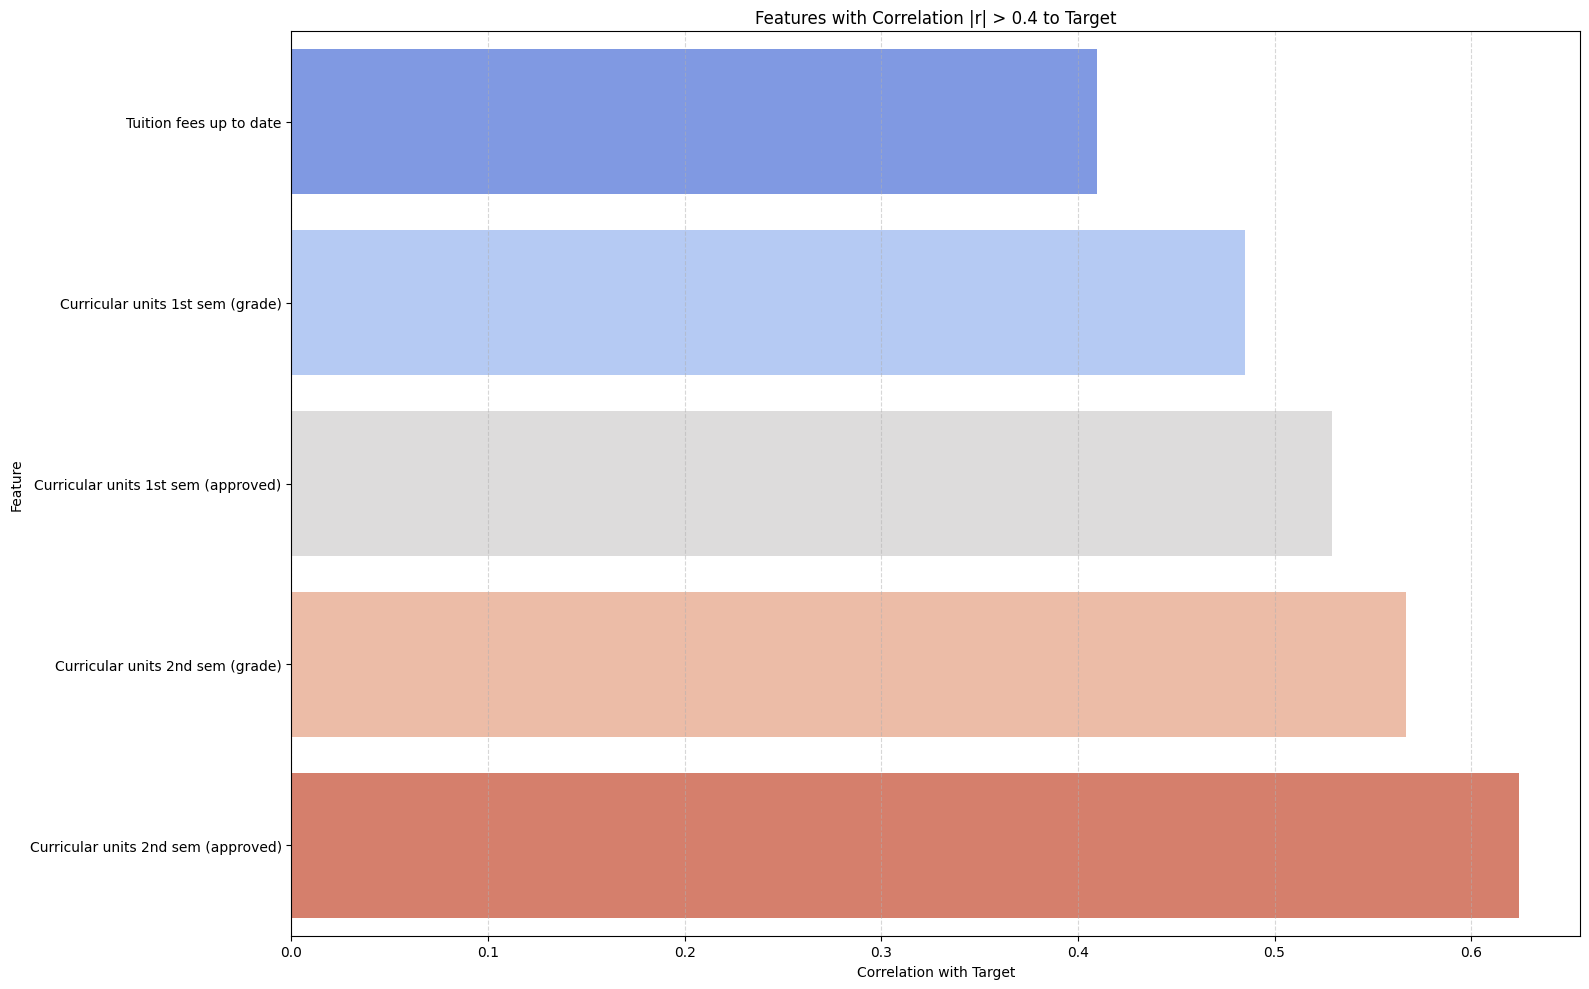

In [174]:
correlations = dataframe.corr()['Target'].drop('Target').sort_values(key=abs, ascending=True)

strong_correlations = correlations[correlations.abs() > threshold]

plt.figure(figsize=(16, 10))
sea.barplot(x=strong_correlations.values, y=strong_correlations.index, palette='coolwarm')
plt.title(f'Features with Correlation |r| > {threshold} to Target')
plt.xlabel('Correlation with Target')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#TODO: visualization plots

Now we split our data between training and testing. Since our target class is imbalanced, we use SMOTE to help smooth it out.

In [175]:
x_train, x_test, y_train, y_test = train_test_split(x_axis, y_axis, test_size=0.2, random_state=40)


smote = SMOTE(random_state=40)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_resampled)
x_test_scaled = scaler.transform(x_test)



The next step is to train our first model which is a Decision Tree Classifier.

In [176]:
clf = DecisionTreeClassifier(random_state=40)
start_train_dt = time.time()
clf.fit(x_train_scaled , y_train_resampled)
end_train_dt = time.time()

We test our Decision Tree with the X axis test data.

In [177]:
start_test_dt = time.time()
y_pred_dt = clf.predict(x_test_scaled)
end_test_dt = time.time()

Finally we check wether our Decision Tree was sucessful or not and categorize it in several metrics.

Acuracy: 0.6633
Precision: 0.6756
Recall: 0.6633
F1-Score: 0.6685
Confusion Matrix:


Classification Report:

              precision    recall  f1-score   support

           0       0.71      0.67      0.69       287
           1       0.39      0.46      0.42       169
           2       0.77      0.74      0.75       429

    accuracy                           0.66       885
   macro avg       0.62      0.62      0.62       885
weighted avg       0.68      0.66      0.67       885

Training time: 0.0859 seconds
Testing time: 0.0013 seconds


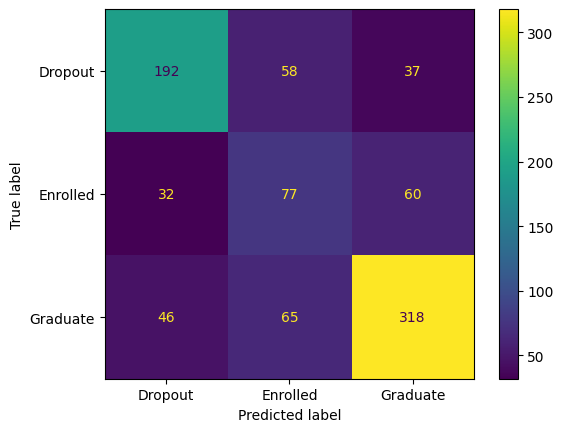

In [178]:
accuracy_dt = skl.metrics.accuracy_score(y_test, y_pred_dt)
precision_dt = skl.metrics.precision_score(y_test, y_pred_dt, average="weighted", zero_division=0)
recal_dt = skl.metrics.recall_score(y_test, y_pred_dt, average="weighted", zero_division=0)
f1_score_dt = skl.metrics.f1_score(y_test, y_pred_dt, average="weighted", zero_division=0)
confusion_matrix_dt = skl.metrics.confusion_matrix(y_test,y_pred_dt)


print(f"Acuracy: {accuracy_dt:.4f}")
print(f"Precision: {precision_dt:.4f}")
print(f"Recall: {recal_dt:.4f}")
print(f"F1-Score: {f1_score_dt:.4f}")
labels = ['Dropout', 'Enrolled', 'Graduate']
print("Confusion Matrix:\n")
skl.metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_dt, display_labels=labels).plot()
print("\nClassification Report:\n")
print(skl.metrics.classification_report(y_test,y_pred_dt, zero_division=0))
print(f"Training time: {end_train_dt-start_train_dt:.4f} seconds")
print(f"Testing time: {end_test_dt-start_test_dt:.4f} seconds")



Here's the visual representation of the Decision Tree.

In [179]:
# plt.figure(figsize=(16,10))
# skl.tree.plot_tree(clf, filled=True, feature_names=x_axis.columns, class_names=True)
# plt.title("Decision Tree Visualization")
# plt.show()

Now we will train our second model, Neural Networks.

In [180]:
mlp = MLPClassifier(hidden_layer_sizes=(256,128,64,), activation='relu', solver='adam', max_iter=1000, early_stopping=True,random_state=40)

start_train_nn = time.time()
mlp.fit(x_train_scaled , y_train_resampled)
end_train_nn = time.time()

TODO:

In [181]:
start_test_nn = time.time()
y_pred_nn = mlp.predict(x_test_scaled)
end_test_nn = time.time()

TODO:

Acuracy: 0.7435
Precision: 0.7453
Recall: 0.7435
F1-Score: 0.7429
Confusion Matrix:


Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.72      0.77       287
           1       0.48      0.49      0.49       169
           2       0.80      0.86      0.83       429

    accuracy                           0.74       885
   macro avg       0.70      0.69      0.69       885
weighted avg       0.75      0.74      0.74       885

Training time: 2.9403 seconds
Testing time: 0.0043 seconds


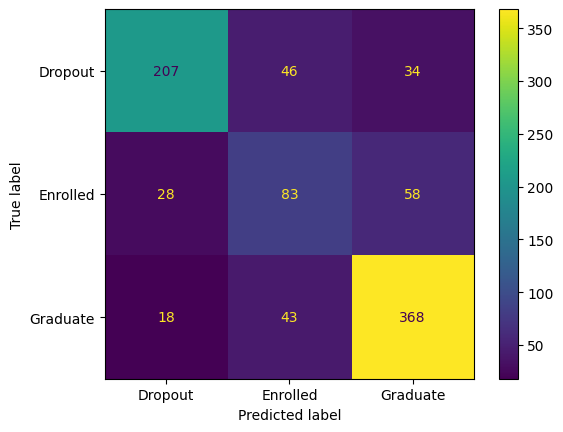

In [182]:
accuracy_nn = skl.metrics.accuracy_score(y_test, y_pred_nn)
precision_nn = skl.metrics.precision_score(y_test, y_pred_nn, average="weighted", zero_division=0)
recal_nn = skl.metrics.recall_score(y_test, y_pred_nn, average="weighted", zero_division=0)
f1_score_nn = skl.metrics.f1_score(y_test, y_pred_nn, average="weighted", zero_division=0)
confusion_matrix_nn = skl.metrics.confusion_matrix(y_test,y_pred_nn)


print(f"Acuracy: {accuracy_nn:.4f}")
print(f"Precision: {precision_nn:.4f}")
print(f"Recall: {recal_nn:.4f}")
print(f"F1-Score: {f1_score_nn:.4f}")
labels = ['Dropout', 'Enrolled', 'Graduate']
print("Confusion Matrix:\n")
skl.metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_nn, display_labels=labels).plot()
print("\nClassification Report:\n")
print(skl.metrics.classification_report(y_test,y_pred_nn, zero_division=0))
print(f"Training time: {end_train_nn-start_train_nn:.4f} seconds")
print(f"Testing time: {end_test_nn-start_test_nn:.4f} seconds")